# Identification of missing input distributions with an inverse multi-modal Polynomial Chaos approach based on scarce data

# 引言
最近读到 [*Identification of missing input distributions with an inverse multi-modal Polynomial Chaos approach based on scarce data*](https://www.sciencedirect.com/science/article/pii/S0266892021000229)这篇关于稀疏数据下的参数反演的文章。感觉普适性很强，所以利用python对文章的主要思想做一个实现。

文章的核心方法可以由图1很好的表述。
![](https://i.niupic.com/images/2022/03/29/9XQq.png)

整个参数反演的算法过程依图1分别包含上中下三条路径。
- 最上的路径A表示实验中数据的采集，与统计分析。
- 中间的路径表示了不确定性由输入参数经过数学模型的传播过程。
- 通过对比实验数据与计算结果，文章建立了一个针对未知输入参数的反演优化过程。
接下来我们尝试将三个过程分别利用python来做一个简单实践。

## 1. 实验数据的处理
首先我们把实验数据的经验累计密度函数表示出来。在本示例中，认为给出了6组实验数据
```python
exp = [-5, -1, 0, 2, 2, 7]
```

首先，我们给出依据实验数据判定经验密度函数的ecdf函数，然后我们将该函数绘制成图。

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
import collections
import numpy as np
import matplotlib.pyplot as plt


def ecdf(exp):
    exp_ou = sorted(set(exp))
    freq = [collections.Counter(exp)[i] for i in exp_ou]
    # print(f"freq=")
    cdf = np.cumsum(freq) / sum(freq)
    # print(f"cdf=")
    return dict(zip(exp_ou, cdf))


In [3]:
exp = [-5, -1, 0, 2, 2, 7]
exp = [i + 1 for i in exp]

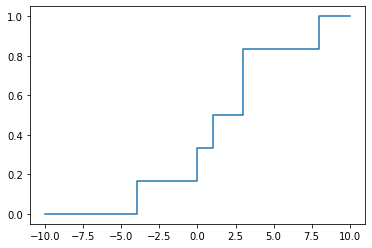

In [4]:
exp_ou = sorted(set(exp))
y_ecdf = [ecdf(exp)[i] for i in exp_ou]

plt.step([-10, *exp_ou, 10], [0, *y_ecdf, 1], where="post")

## 2.基于模型的正向推演与ks检测

在本实验中，我们假定所研究的问题的数学模型已知，不失一般性，我们设模型表达式为，
$$
y = f(x1,x2)=2(x1+x2)
$$
,
且已知$x1$满足标准正态分布，而$x2$也舒服正态分布，可是参数未知。本示例的最终目标就是通过不确定性传播与统计分析，结合反向优化算法，确定$x2$的均值$\mu$,与方差$\sigma$。

In [6]:
def model(x1, x2):
    return 2 * (x1 + x2)

利用kde推导cdf函数

In [5]:
from scipy.special import ndtr


def kde_cdf(kde, x):
    # return tuple(ndtr(np.ravel(item - kde.dataset) / kde.factor).mean() for item in x)
    return np.array(
        [ndtr(np.ravel(item - kde.dataset) / kde.factor).mean() for item in x]
    )

In [7]:
samples = 10_000
x1 = stats.norm(0, 1)

mu = 0
sigma = 1

x2 = stats.norm(mu, sigma)

y = model(x1.rvs(samples), x2.rvs(samples))
kde = stats.gaussian_kde(y)

(array([0.00079653, 0.00652161, 0.02952149, 0.07407754, 0.12834132,
        0.13351879, 0.08353636, 0.03235914, 0.00776619, 0.00139393]),
 array([-10.18070691,  -8.1720008 ,  -6.16329469,  -4.15458858,
         -2.14588247,  -0.13717636,   1.87152975,   3.88023585,
          5.88894196,   7.89764807,   9.90635418]),
 <BarContainer object of 10 artists>)

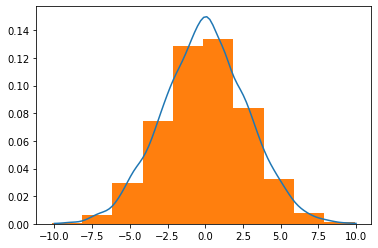

In [8]:
x = np.linspace(-10, 10, 100)

plt.plot(x, kde.pdf(x))
plt.hist(y, density=True)

当$x2$取为标准正态分布时，模型结果与实验记录差距较大。

ks=0.16686698078140644


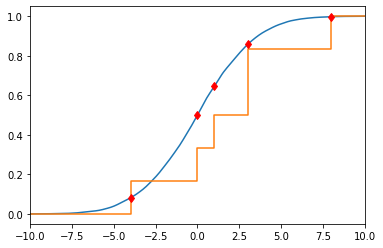

In [9]:
x_test = np.linspace(-10, 10, 200)

plt.plot(x_test, kde_cdf(kde, x_test))
plt.step([-10, *exp_ou, 10], [0, *y_ecdf, 1], where="post")
plt.xlim([-10, 10])
plt.plot(exp_ou, kde_cdf(kde, exp_ou), "rd")

ds = kde_cdf(kde, exp_ou) - y_ecdf
ks = np.abs(ds).max()
print(f"{ks=}")

本示例采用ks距离来衡量两分布的差异程度。
$$
d_{ks}=max(cdf(x)), x\in exp
$$
具体定义参见[ks检验](https://zhuanlan.zhihu.com/p/292678346)

## 3.基于ks距离的参数优化反演。

利用scipy minimize进行优化反演，优化目标为模型结果与实验记录的ks距离最小。

In [10]:
from scipy.optimize import minimize


def obj_ks(x0):
    samples = 200_000
    mu = x0[0]
    sigma = x0[1]
    x2 = stats.norm(mu, sigma)
    y = model(x1.rvs(samples, random_state=1), x2.rvs(samples, random_state=1))
    kde = stats.gaussian_kde(y)
    ds = kde_cdf(kde, exp_ou) - y_ecdf
    # print(f"{ks=}")
    return np.abs(ds).max()

In [11]:
x0 = np.array([0, 1])
res = minimize(obj_ks, x0, method="nelder-mead")
# res = minimize(obj_ks, x0)
res

 final_simplex: (array([[0.3494666 , 0.70578799],
       [0.34944361, 0.70572982],
       [0.34947286, 0.70573745]]), array([0.08391462, 0.08391892, 0.08392066]))
           fun: 0.08391462235300451
       message: 'Optimization terminated successfully.'
          nfev: 111
           nit: 58
        status: 0
       success: True
             x: array([0.3494666 , 0.70578799])

将反演结果绘制成图，我们可以看出，经参数优化反演后，ks距离明显的从0.16下降至0.08，同时cdf函数的趋势也与实验数据更为吻合。

In [12]:
y = model(
    x1.rvs(samples, random_state=1), stats.norm(*res.x).rvs(samples, random_state=1)
)
kde = stats.gaussian_kde(y)

ks=0.083717486081684
res.x=array([0.3494666 , 0.70578799])


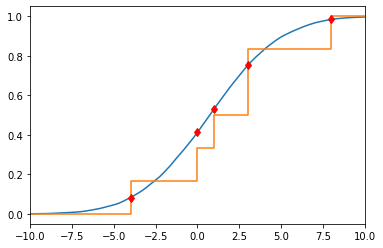

In [13]:
x_test = np.linspace(-10, 10, 200)

plt.plot(x_test, kde_cdf(kde, x_test))
plt.step([-10, *exp_ou, 10], [0, *y_ecdf, 1], where="post")
plt.xlim([-10, 10])
plt.plot(exp_ou, kde_cdf(kde, exp_ou), "rd")
ds = kde_cdf(kde, exp_ou) - y_ecdf
ks = np.abs(ds).max()
print(f"{ks=}")
print(f"{res.x=}")